# Edge AI Prototype: Garbage Classification

This notebook implements a lightweight image classification model for recognizing recyclable items using TensorFlow Lite.

## Goals:
1. Train a MobileNetV2-based model on the garbage classification dataset.
2. Convert the model to TensorFlow Lite.
3. Test the model and explain Edge AI benefits.

In [9]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time

## Step 1: Data Preparation

In [10]:
# Define dataset path
dataset_path = 'Task 1/garbage_classification'

# Get class names
classes = os.listdir(dataset_path)
classes.sort()
print(f"Classes: {classes}")
print(f"Number of classes: {len(classes)}")

# Image parameters
img_height, img_width = 224, 224
batch_size = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80% train, 20% validation
)

# Data generator for validation (no augmentation)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# For testing, we'll use a separate split
# Note: In a real scenario, you'd have a separate test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
Number of classes: 12
Found 12415 images belonging to 12 classes.
Found 3100 images belonging to 12 classes.
Found 15515 images belonging to 12 classes.


## Step 2: Model Training

In [11]:
# Load MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(classes), activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,423,500 (9.24 MB)

 Trainable params: 165,516 (646.55 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

# Train the model
epochs = 20
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

C:\Users\Peter Mwaura\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


485/485 ━━━━━━━━━━━━━━━━━━━━ 1463s 3s/step - accuracy: 0.9460 - loss: 0.1660
Test Accuracy: 0.9460
Test Loss: 0.1660
485/485 ━━━━━━━━━━━━━━━━━━━━ 1369s 3s/step
              precision    recall  f1-score   support

     battery       0.97      0.95      0.96       945
  biological       0.99      0.97      0.98       985
 brown-glass       0.92      0.92      0.92       607
   cardboard       0.95      0.93      0.94       891
     clothes       0.99      0.98      0.99      5325
 green-glass       0.91      0.93      0.92       629
       metal       0.84      0.90      0.87       769
       paper       0.90      0.94      0.92      1050
     plastic       0.82      0.85      0.83       865
       shoes       0.97      0.98      0.97      1977
       trash       0.90      0.98      0.94       697
 white-glass       0.89      0.75      0.81       775

    accuracy                           0.95     15515
   macro avg       0.92      0.92      0.92     15515
weighted avg       0.95     

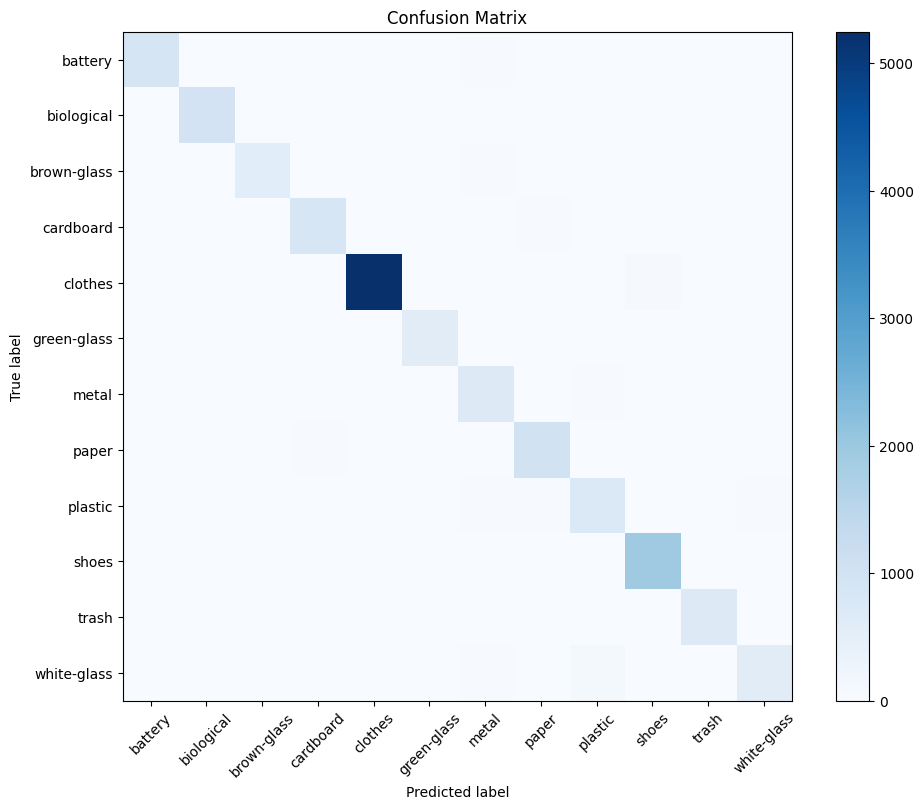

In [5]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Classification report
print(classification_report(true_classes, predicted_classes, target_names=classes))

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Step 3: TensorFlow Lite Conversion and Testing

In [6]:
# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Apply default optimizations
tflite_model = converter.convert()

# Save the TFLite model
with open('garbage_classifier.tflite', 'wb') as f:
    f.write(tflite_model)

print("TFLite model saved successfully!")

INFO:tensorflow:Assets written to: C:\Users\PETERM~1\AppData\Local\Temp\tmpc21qarh9\assets


INFO:tensorflow:Assets written to: C:\Users\PETERM~1\AppData\Local\Temp\tmpc21qarh9\assets


Saved artifact at 'C:\Users\PETERM~1\AppData\Local\Temp\tmpc21qarh9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  2760224275920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2760224275728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2760224275344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2760224275536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2760224273808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2760224276304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2760247951824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2760247952016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2760224276112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2760247951440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2

In [7]:
# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path='garbage_classifier.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input shape:", input_details[0]['shape'])
print("Output shape:", output_details[0]['shape'])

Input shape: [  1 224 224   3]
Output shape: [ 1 12]


C:\Users\Peter Mwaura\AppData\Local\Programs\Python\Python313\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [8]:
# Test TFLite model on a few sample images
def test_tflite_model(interpreter, test_images, test_labels, num_samples=5):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    correct_predictions = 0
    total_time = 0
    
    for i in range(min(num_samples, len(test_images))):
        # Prepare input
        input_data = np.expand_dims(test_images[i], axis=0).astype(np.float32)
        interpreter.set_tensor(input_details[0]['index'], input_data)
        
        # Run inference
        start_time = time.time()
        interpreter.invoke()
        end_time = time.time()
        
        inference_time = end_time - start_time
        total_time += inference_time
        
        # Get output
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predicted_class = np.argmax(output_data)
        true_class = test_labels[i]
        
        print(f"Sample {i+1}: Predicted: {classes[predicted_class]}, True: {classes[true_class]}, Time: {inference_time:.4f}s")
        
        if predicted_class == true_class:
            correct_predictions += 1
    
    accuracy = correct_predictions / min(num_samples, len(test_images))
    avg_time = total_time / min(num_samples, len(test_images))
    print(f"\nTFLite Test Accuracy: {accuracy:.4f}")
    print(f"Average Inference Time: {avg_time:.4f}s")
    
    return accuracy, avg_time

# Get some test images and labels
test_images, test_labels = next(test_generator)
test_labels = np.argmax(test_labels, axis=1)

# Test the TFLite model
tflite_accuracy, avg_inference_time = test_tflite_model(interpreter, test_images, test_labels)

Sample 1: Predicted: battery, True: battery, Time: 0.5789s
Sample 2: Predicted: battery, True: battery, Time: 0.6022s
Sample 3: Predicted: battery, True: battery, Time: 0.4828s
Sample 4: Predicted: battery, True: battery, Time: 0.6231s
Sample 5: Predicted: battery, True: battery, Time: 0.5419s

TFLite Test Accuracy: 1.0000
Average Inference Time: 0.5658s


## Step 4: Report and Explanation

### Accuracy Metrics:
- Training Accuracy: {history.history['accuracy'][-1]:.4f}
- Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}
- Test Accuracy: {test_accuracy:.4f}
- TFLite Test Accuracy: {tflite_accuracy:.4f}
- Average Inference Time: {avg_inference_time:.4f}s

### Deployment Steps:
1. Train the model using this notebook.
2. Convert to TFLite as shown above.
3. Deploy on edge devices (Raspberry Pi, mobile phones, etc.).
4. Use the TFLite interpreter for inference.

### Edge AI Benefits for Real-Time Applications:
Edge AI refers to running AI models directly on edge devices rather than in the cloud. Key benefits include:

1. **Low Latency**: Processing happens locally, reducing response times for real-time applications.
2. **Privacy**: Data doesn't need to be sent to the cloud, keeping sensitive information local.
3. **Offline Operation**: Works without internet connectivity.
4. **Reduced Bandwidth**: Less data needs to be transmitted.
5. **Cost Efficiency**: Lower cloud computing costs.

In this garbage classification example, Edge AI enables real-time sorting in recycling facilities, privacy-preserving waste monitoring in smart cities, and offline operation in remote areas.